In [126]:
import pandas as pd
import numpy as np
import re
import plotly.graph_objects as go
from sklearn.metrics import r2_score

<Axes: >

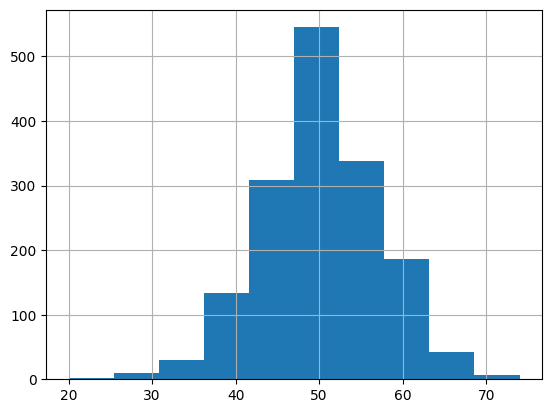

In [101]:
oes_df = pd.read_excel("MSA_M2019_dl.xlsx")
oes_df = oes_df[oes_df["o_group"] == "major"]
oes_df = oes_df[["area_title", "occ_title", "occ_code", "a_mean"]].drop_duplicates()
resid_df = pd.read_pickle("Run1_2019.pkl")
display(resid_df["n_ads"].hist())
resid_df = resid_df[resid_df["id"].map(lambda x: "soc" in x)]
resid_df = resid_df[["city_state", "id", "r_mean"]]

In [102]:
def clean_loc(text): 
    text = " ".join(text.split(" ")[:-1])
    text = text.replace("-", " ")
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)
    return text.lower().strip()

def city_map(val, vals):

    for v in vals:
        if val in v:
            return v

resid_df["clean_loc"] = resid_df["city_state"].map(clean_loc)
oes_df["clean_loc"] = oes_df["area_title"].map(clean_loc)

oes_df["map_loc"] = oes_df["clean_loc"]
resid_df["map_loc"] = resid_df["clean_loc"].map(lambda x: city_map(x, oes_df["clean_loc"].unique()))

resid_df["soc_code"] = resid_df["id"].map(lambda x: int(x.split("_")[1]))
oes_df["soc_code"] = oes_df["occ_code"].map(lambda x: int(x.split("-")[0]))

resid_df = resid_df[resid_df["map_loc"].notnull()]
oes_df = oes_df[oes_df["map_loc"].notnull()]

display(resid_df.head())
display(oes_df.head())

,city_state,id,r_mean,clean_loc,map_loc,soc_code
0,new york NY,soc_43,3958.0,new york,new york newark jersey city,43
1,los angeles CA,soc_43,2682.0,los angeles,los angeles long beach anaheim,43
2,houston TX,soc_43,-2423.0,houston,houston the woodlands sugar land,43
3,chicago IL,soc_43,-390.0,chicago,chicago naperville elgin,43
4,dallas TX,soc_43,-2088.0,dallas,dallas fort worth arlington,43


,area_title,occ_title,occ_code,a_mean,clean_loc,map_loc,soc_code
1,"Abilene, TX",Management Occupations,11-0000,90500,abilene,abilene,11
18,"Abilene, TX",Business and Financial Operations Occupations,13-0000,67520,abilene,abilene,13
36,"Abilene, TX",Computer and Mathematical Occupations,15-0000,62970,abilene,abilene,15
44,"Abilene, TX",Architecture and Engineering Occupations,17-0000,72440,abilene,abilene,17
54,"Abilene, TX","Life, Physical, and Social Science Occupations",19-0000,58360,abilene,abilene,19


In [103]:
print("OES MSA by Occ Pairs: ", len(oes_df))
print("Resid City by Occ Pairs: ", len(resid_df))

OES MSA by Occ Pairs:  8645
Resid City by Occ Pairs:  710


In [ ]:
cmb_df = resid_df.merge(
    oes_df,
    on = ["map_loc", "soc_code"],
    how="left",
)

,map_loc,soc_code,occ_title,residuals,oes_est
0,albuquerque,11,Management,-6190.0,107400.0
1,albuquerque,13,Business and Financial Operations,-6482.0,70120.0
2,albuquerque,15,Computer and Mathematical,-8015.0,79330.0
3,albuquerque,25,Educational Instruction and Library,-6249.0,53370.0
4,albuquerque,29,Healthcare Practitioners and Technical,-7055.0,86020.0
...,...,...,...,...,...
595,wichita,35,Food Preparation and Serving Related,-5552.0,22300.0
596,wichita,39,Personal Care and Service,-6646.0,28670.0
597,wichita,41,Sales and Related,-4351.0,39360.0
598,wichita,43,Office and Administrative Support,-5701.0,36980.0


In [123]:
resid_df[resid_df["city_state"].map(lambda x: "portland" in x.lower())]

,city_state,id,r_mean,clean_loc,map_loc,soc_code
18,portland OR,soc_43,0.0,portland,portland vancouver hillsboro,43
18,portland OR,soc_41,0.0,portland,portland vancouver hillsboro,41
18,portland OR,soc_53,0.0,portland,portland vancouver hillsboro,53
18,portland OR,soc_11,0.0,portland,portland vancouver hillsboro,11
18,portland OR,soc_29,0.0,portland,portland vancouver hillsboro,29
18,portland OR,soc_35,0.0,portland,portland vancouver hillsboro,35
18,portland OR,soc_13,0.0,portland,portland vancouver hillsboro,13
18,portland OR,soc_15,0.0,portland,portland vancouver hillsboro,15
18,portland OR,soc_25,0.0,portland,portland vancouver hillsboro,25
18,portland OR,soc_39,0.0,portland,portland vancouver hillsboro,39


In [ ]:
cmb_df2 = cmb_df.groupby(["map_loc", "soc_code", "occ_title"]).agg({"r_mean": "mean", "a_mean": "mean"}).reset_index()
cmb_df2["occ_title"] = cmb_df2["occ_title"].map(lambda x: " ".join(x.split(" ")[:-1]))
cmb_df2.rename(columns={"r_mean": "residuals", "a_mean": "oes_est"}, inplace=True)
cmb_df2["residuals"] = cmb_df2["residuals"].astype(float)
cmb_df2["oes_est"] = cmb_df2["oes_est"].astype(float)

for occ in cmb_df2["occ_title"].unique():
    # remove the value for portland from the oes_est
    portland_val = cmb_df2[(cmb_df2["occ_title"] == occ) & (cmb_df2["map_loc"].str.contains("portland"))]["oes_est"].values[0]
    cmb_df2.loc[cmb_df2["occ_title"] == occ, "oes_est"] = cmb_df2[cmb_df2["occ_title"] == occ]["oes_est"].map(lambda x: x - portland_val)

# plot plotly scatter plot of residuals vs OES estimates colored by discrete occ_title with labeled legend, log both axes
fig = go.Figure()
for occ in cmb_df2["occ_title"].unique():
    fig.add_trace(
        go.Scatter(
            x = cmb_df2[cmb_df2["occ_title"] == occ]["oes_est"],
            y = cmb_df2[cmb_df2["occ_title"] == occ]["residuals"],
            mode = "markers",
            name = occ,
            marker=dict(size=5),
        )
    )
fig.update_layout(
    title="Residuals vs OES Estimates by MSA-Occupation",
    xaxis_title="OES Estimates",
    yaxis_title="Residuals",
    legend_title_text="Occupation",
    width=800,
    height=600,
    xaxis_range=[-40_000, 60_000],
    yaxis_range=[-40_000, 60_000]
)
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))

# create overall r2
r2 = r2_score(cmb_df2["oes_est"], cmb_df2["residuals"])
print("Overall R2: ", r2)
fig.add_annotation(
    xref="paper", yref="paper",
    x=0.1, y=0.95,
    text=f"Overall R2: {r2:.2f}",
    showarrow=False,
    font=dict(size=16)
)

# create diagonal line of equality
x_vals = np.linspace(-40_000, 60_000, 100)
y_vals = x_vals
fig.add_trace(
    go.Scatter(
        x=x_vals,
        y=y_vals,
        mode="lines",
        name="Line of Equality",
        line=dict(color="red", width=2),
    )
)

fig.show()

Overall R2:  0.3930253994888768


In [141]:
# show scatter plots for each occupation with a linear regression line
for occ in cmb_df2["occ_title"].unique():
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x = cmb_df2[cmb_df2["occ_title"] == occ]["oes_est"],
            y = cmb_df2[cmb_df2["occ_title"] == occ]["residuals"],
            mode = "markers",
            name = occ,
            marker=dict(size=5),
        )
    )
    fig.update_layout(
        title=f"Residuals vs OES Estimates by MSA-Occupation: {occ}",
        xaxis_title="OES Estimates",
        yaxis_title="Residuals",
        legend_title_text="Occupation",
        width=800,
        height=600,
        xaxis_range=[-40_000, 60_000],
        yaxis_range=[-40_000, 60_000]
    )
    fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
    r2 = r2_score(cmb_df2[cmb_df2["occ_title"] == occ]["oes_est"], cmb_df2[cmb_df2["occ_title"] == occ]["residuals"])
    print("Overall R2: ", r2)
    fig.add_annotation(
        xref="paper", yref="paper",
        x=0.1, y=0.95,
        text=f"Overall R2: {r2:.2f}",
        showarrow=False,
        font=dict(size=16)
    )

    # create diagonal line of equality
    x_vals = np.linspace(-40_000, 60_000, 100)
    y_vals = x_vals
    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=y_vals,
            mode="lines",
            name="Line of Equality",
            line=dict(color="red", width=2),
        )
    )

    fig.show()

Overall R2:  0.23020752054369376


Overall R2:  0.42615956038601244


Overall R2:  0.49031528610748143


Overall R2:  -0.13713247440306642


Overall R2:  -0.13287181046992536


Overall R2:  0.5655861986130066


Overall R2:  0.7203193810962484


Overall R2:  0.2390979707714881


Overall R2:  0.7708539936678009


Overall R2:  0.4089739602457738
